# Exercise 1: Heat Conduction for multiple layers with variable properties
## Description
The development of the temperature field for an arbitrary building component should be calculated. The component can consist of multiple layers with varying properties. Furthermore, the grid-sizes may very in the different layers.
```{figure} Ex1/building_comp.png
---
height: 200px
name: cond_bound_cell
---
Figure from problem statement. {cite}`hagentoftIntroductionBuildingPhysics2001`.
```

The models physical behaviour is described by the governing differential equation for heat conduction:

$$
\rho c \frac{dT}{dt} = \nabla \cdot (\lambda \nabla T)
$$ (ex_heat_eq)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Program Design
First we are going to create some classes to easier describe the problem.
- Cell_Mat: This class should resemble a certain martial, with the needed properties to define needed for the calculation.
- Boundary_Cell: Class for the boundary layer. This one only has a temperature and a given resistance.
- We will not create a class for the simulation, because this would clutter the notebook. Feel free to do so on your own if you like to.

In [3]:
class Cell_Mat(object):
    def __init__(self, *args, **kwargs):
        # Discretization
        self.dx = kwargs.get('dx', None)
        self.face_e = kwargs.get('face_e', None)
        self.face_w = kwargs.get('face_w', None)

        # Material parameters
        self.lamb = kwargs.get('lamb', None)
        self.cp = kwargs.get('cp', None)
        self.rho = kwargs.get('rho', None)
        self.RC = self.dx / self.lamb

        # Fields
        self.Tn = kwargs.get('Tn', None)
        self.Tn_plus = kwargs.get('Tn_plus', None)
        self.dT = kwargs.get('dT', None)

        # Neighbours
        self.cell_E = kwargs.get('cell_E', None)
        self.cell_W = kwargs.get('cell_W', None)


class Boundary_Cell(object):
    def __init__(self, *args, **kwargs):
        # Fields
        self.Tn = kwargs.get('Tn', None)
        self.Tn_plus = kwargs.get('Tn_plus', None)

        self.RC = kwargs.get('RC', None)

        # Neighbours
        # No neighbours. This is the end of the sim domain

## Input data
Here we create our input data for our calculation:

In [4]:
# ----------------------------------
# Define simulation domain
# ----------------------------------

# Define Simulation parameters
sim_time = 3600 * 24 * 1

# Define mat cells
eps = [0] * 20
eps = [Cell_Mat(dx=0.01, lamb=0.04, cp=1470, rho=1000, Tn=10) for i in eps]
concrete = [0] * 10
concrete = [Cell_Mat(dx=0.015, lamb=2.3, cp=1000, rho=2500, Tn=10) for i in concrete]
plaster = [0] * 4
plaster = [Cell_Mat(dx=0.005, lamb=0.9, cp=1000, rho=2000, Tn=10) for i in plaster]

# Define BCs
BC_left = [Boundary_Cell(Tn=0, RC=0.04)]
BC_right = [Boundary_Cell(Tn=20, RC=0.10)]

# Assemble simulation domain
layers = [eps, concrete, plaster]
mat_domain = eps + concrete + plaster
whole_domain = BC_left + mat_domain + BC_right
num_cells = whole_domain.__len__()

## Numerics
As we heard in the lecture, the concept of RC-Networks is well suited, to implement a numerical solution of this problem. We will discretize Equation {eq}`ex_heat_eq` exemplary for the left boundary and in a general form for an internal cell with the Finite Volume Method.

```{figure} Ex1/network_multilayer.png
---
height: 200px
name: cond_bound_cell
---
RC-Network for building component {cite}`hagentoftIntroductionBuildingPhysics2001`.
```

### Internal Cells - Numerical Formulation
When working with Finite Volumes it is common practice to use the following notation:
- Index of the cell is based on the direction it is situated (P = cell to evaluate, E = cell to the east, W = cell to the west)
- Quantities which are evaluated in the middle of the cells are denoted with capital letters
- Quantities which are evaluated at interfaces/surfaces of the cells are denoted with small letters

```{figure} Ex1/fvm_internal_cell.png
---
height: 200px
name: cond_bound_cell
---
Labeling convention for FVM.
```



Furthermore, the distances from the middle of one cell to its neighbour should be denoted as $\Delta x_{w}$ and $\Delta x_{e}$ with the definition:

$$
\Delta x_{w} = \frac{\Delta x_{W}}{2} + \frac{\Delta x_{P}}{2}
$$

$$
\Delta x_{e} = \frac{\Delta x_{P}}{2} + \frac{\Delta x_{E}}{2}
$$

**LHS of Equation {eq}`ex_heat_eq`:**
Integrating over the surfaces of the control-volume and evaluating them numerically in 1D gives us for the LHS

$$
\int_{w}^{e} \rho c \frac{dT(x)}{dt} \,dx = \rho c \frac{dT(x)}{dt} \Delta x = \rho_{P} c_{P}  \frac{T_{P}^{n+1} - T_{P}^{n}}{\Delta t} \Delta x_{P}.
$$

**RHS of Equation {eq}`ex_heat_eq`:**
Integrating over the surfaces of the control-volume and evaluating them numerically in 1D gives us for the RHS

$$
\int_{w}^{e} \frac{d}{dx} \lambda(x) \frac{dT(x)}{dx}\,dx = \left[\lambda(x) \frac{dT(x)}{dx}\right]_{w}^{e} = \lambda_{e} \frac{T_{e}}{dx} - \lambda_{w} \frac{T_{w}}{dx} = \lambda_{e} \frac{T_{E} - T_{P}}{\Delta x_{e}} - \lambda_{w} \frac{T_{P} - T_{W}}{\Delta x_{w}}.
$$
This results in the numerical formulation of Equation {eq}`ex_heat_eq` for an internal cell with an explicit procedure as

$$
\rho_{P} c_{P}  \frac{T_{P}^{n+1} - T_{P}^{n}}{\Delta t} \Delta x_{P} = \lambda_{e} \frac{T_{E} - T_{P}}{\Delta x_{e}} - \lambda_{w} \frac{T_{P} - T_{W}}{\Delta x_{w}}
$$

Solving for the unknown temperature for the next time step using the identity $F_{o}^{*} = \frac{\Delta t}{\rho_{P} c_{P}  \Delta x_{P}}$ (which we'll call a modified Fourier-Number) gives us

$$
T^{n+1} = T^{n} + F_{o}^{*} \left(\frac{\lambda_{e}}{\Delta x_{e}} T_{E} - \left(\frac{\lambda_{e}}{\Delta x_{e}} + \frac{\lambda_{w}}{\Delta x_{w}}\right) T_{P} - \frac{\lambda_{w}}{\Delta x_{w}} T_{W}\right)
$$(ex_heat_num_eq)

The unknown variables at the interfaces $\lambda_{e}, \lambda_{w}$ can be derived with the theory the RC-Networks are based on. With that we can reformulate our conductivity parameters in Equation {eq}`ex_heat_num_eq` as

```{figure} Ex1/cond_int_cell.png
---
height: 150px
name: cond_bound_cell
---
Definition of conductivity for an interior cell  {cite}`hagentoftIntroductionBuildingPhysics2001`.
```
$$
K_{e} = \frac{1}{\frac{\Delta x_{E}/2}{\lambda_{E}} + R_{c_{e}} + \frac{\Delta x_{P}/2}{\lambda_{P}}}
$$

and

$$
K_{w} = \frac{1}{\frac{\Delta x_{P}/2}{\lambda_{P}} + R_{c_{w}} + \frac{\Delta x_{W}/2}{\lambda_{W}}}
$$

with $R_{c_{e}}$ and $R_{c_{w}}$ denoting resistances right in the interface layer.

Inserting above expressions in Equation {eq}`ex_heat_num_eq` we get

$$
T^{n+1} = T^{n} + F_{o}^{*} \left(K_{e} T_{E} - \left(K_{e} + K_{w}\right) T_{P} - K_{w} T_{W}\right)
$$(ex_heat_num_cond_eq)

### Left Boundary-Numerical Formulation
The numerical formulation for the boundaries will be shown exemplary for the left- or west-boundary of the simulation domain. The formulation for the other side is analogous.

As with the internal cell, we will take advantage of the conductivity properties of such a boundary node. For a boundary condition which prescribes a static quantitiy (Dirichlet-Boundary-Condition) when using RC-Networks only the conductivity parameters have to be adjusted

```{figure} Ex1/cond_bound_cell.png
---
height: 150px
name: cond_bound_cell
---
Definition of conductivity at the boundary  {cite}`hagentoftIntroductionBuildingPhysics2001`.
```

$$
K_{BC_{Left}} = \frac{1}{\frac{\Delta x_{P}/2}{\lambda_{P}} + R_{BC_{Left}} + 0}
$$

with $R_{BC_{Left}}$ being known resistance prescribed by the boundary condition. Since this formulation takes in account that the boundary is applied at the surface of the Cell we can simply adapt Equation {eq}`ex_heat_num_cond_eq`.

$$
T^{n+1} = T^{n} + F_{o}^{*} \left(K_{e} T_{E} - \left(K_{e} + K_{w}\right) T_{P} - K_{BC_{Left}} T_{BC_{Left}}\right)
$$(ex_heat_num_cond_bound_eq)

### Assembling of Conductivity Matrix
To solve the system for all cells at each time step we can come up with a matrix-vector formulations of Equation {eq}`ex_heat_num_cond_eq` and Equation {eq}`ex_heat_num_cond_bound_eq`.



In this formulation the vector $T^{n}$ consists of the temperature at each discretization point at the current timestep $n$

$$ T^{n} =
 \begin{bmatrix}
T_{BC_{Left}} \\
T_{1} \\
  \\
T_{m} \\
T_{m+1} \\
  \\
T_{BC_{Right}}
\end{bmatrix}
$$

$K$ is the conductivity matrix

$$ K =
\begin{bmatrix}
0 & 0 & 0 & (...) &   &   &   \\
K_{BC_{Left}} &  - \left(K_{e} + K_{w}\right) & K_{e} & 0 & (...) &   &   \\
0 & K_{w} &  - \left(K_{e} + K_{w}\right) & K_{e} & 0 & (...) &   \\
  &   & K_{w} &  - \left(K_{e} + K_{w}\right) & K_{e} &   &   \\
  & (...) & 0 & K_{w} &  - \left(K_{e} + K_{w}\right) & K_{e} & 0 \\
  &   & (...) & 0 & K_{w} &  - \left(K_{e} + K_{w}\right) & K_{e} \\
  &   &   & (...) & 0 & 0 & 0
\end{bmatrix}
$$

and $T^{n+1}$ will be the solution vector. This gives us following expression for the unkown temperature-field $T^{n+1}$ of the next timestep  in matrix-vector form

$$
T^{n+1} = T^{n} + F_{o}^{*} K T^{n}
$$


In [5]:
#  Assemble Sim domain into matrices
# Initialise variables

# Apply neighbours
for count, cell in enumerate(mat_domain):
    cell.cell_W = whole_domain[count]
    cell.cell_E = whole_domain[count + 2]

# %%
dx_array = np.array([cell.dx for cell in mat_domain])

Tn = np.array([cell.Tn for cell in whole_domain])
Tn_plus = np.array([cell.Tn_plus for cell in whole_domain])

RC_array = np.array([cell.RC for cell in whole_domain])
RC_W = RC_array[0:-2]
RC_P = RC_array[1:-1]
RC_E = RC_array[2:]
Kw_array = 1 / (RC_W / 2 + RC_P / 2)
Ke_array = 1 / (RC_E / 2 + RC_P / 2)

# Build conductivity matrix [K]
# Create sparse matrix
Left_diagonal = np.eye(num_cells, num_cells, k=-1)
Left_diagonal[1:-1, 0:-2] = Left_diagonal[1:-1, 0:-2] * Kw_array
Right_diagonal = np.eye(num_cells, num_cells, k=1)
Right_diagonal[1:-1, 2:] = Right_diagonal[1:-1, 2:] * Ke_array
Main_Diagonal = np.eye(num_cells, num_cells)
Main_Diagonal[1:-1, 1:-1] = Main_Diagonal[1:-1, 1:-1] * - (Kw_array + Ke_array)
K = Left_diagonal + Main_Diagonal + Right_diagonal
# Multiply with constants
cp_array = np.array([cell.cp for cell in mat_domain])
Left_diagonal = np.eye(num_cells, num_cells, k=-1)
Left_diagonal[1:-1, 0:-2] = Left_diagonal[1:-1, 0:-2] * cp_array
Right_diagonal = np.eye(num_cells, num_cells, k=1)
Right_diagonal[1:-1, 2:] = Right_diagonal[1:-1, 2:] * cp_array
Main_Diagonal = np.eye(num_cells, num_cells)
Main_Diagonal[1:-1, 1:-1] = Main_Diagonal[1:-1, 1:-1] * cp_array
cp_P_constants = Left_diagonal + Main_Diagonal + Right_diagonal
cp_P_constants[cp_P_constants == 0] = 1

rho_array = np.array([cell.rho for cell in mat_domain])
Left_diagonal = np.eye(num_cells, num_cells, k=-1)
Left_diagonal[1:-1, 0:-2] = Left_diagonal[1:-1, 0:-2] * rho_array
Right_diagonal = np.eye(num_cells, num_cells, k=1)
Right_diagonal[1:-1, 2:] = Right_diagonal[1:-1, 2:] * rho_array
Main_Diagonal = np.eye(num_cells, num_cells)
Main_Diagonal[1:-1, 1:-1] = Main_Diagonal[1:-1, 1:-1] * rho_array
rho_P_constants = Left_diagonal + Main_Diagonal + Right_diagonal
rho_P_constants[rho_P_constants == 0] = 1

Left_diagonal = np.eye(num_cells, num_cells, k=-1)
Left_diagonal[1:-1, 0:-2] = Left_diagonal[1:-1, 0:-2] * dx_array
Right_diagonal = np.eye(num_cells, num_cells, k=1)
Right_diagonal[1:-1, 2:] = Right_diagonal[1:-1, 2:] * dx_array
Main_Diagonal = np.eye(num_cells, num_cells)
Main_Diagonal[1:-1, 1:-1] = Main_Diagonal[1:-1, 1:-1] * dx_array
dx_P_constants = Left_diagonal + Main_Diagonal + Right_diagonal
dx_P_constants[dx_P_constants == 0] = 1

### Simulation

As heard in the lecture, we are going to use an explicit Euler scheme. Since we have created a linear equation system for our problem we can solve the whole domain each step with a simple matrix multiplication.

Before running the loop we will check for a suitable timestep with the **Fourier Number**.

In [5]:
# ----------------------
# Simulation
# ----------------------
t = 0
smallest_dx = dx_array.min()
smallest_cp = cp_array.min()
smallest_rho = rho_array.min()
lamb_array = np.array([cell.lamb for cell in mat_domain])
biggest_lamb = lamb_array.max()
dt = 0.5 * smallest_cp * smallest_rho * smallest_dx ** 2 / biggest_lamb

Now we can multiply our conductivity matrix with the missing constants:

In [6]:
# Multiply [K] with constants
K = K / cp_P_constants / rho_P_constants / dx_P_constants * dt
K[0, 0], K[0, 1], K[-1, -1], K[-1, -2] = 0, 0, 0, 0  # ghost lines for boundary conditions
# Rewrite [K] * [T] + [T] with identitiy matrix
I = np.eye(num_cells, num_cells)
L = I + K


And finally run our simulation.

In [7]:
# Simulation Loop
while t <= sim_time:
    # Calculate temperature field
    # ------------------------------
    # Tn_plus = K @ Tn + Tn
    Tn_plus = L @ Tn
    Tn = Tn_plus
    t += dt

## Plotting the results
Let's plot our results.

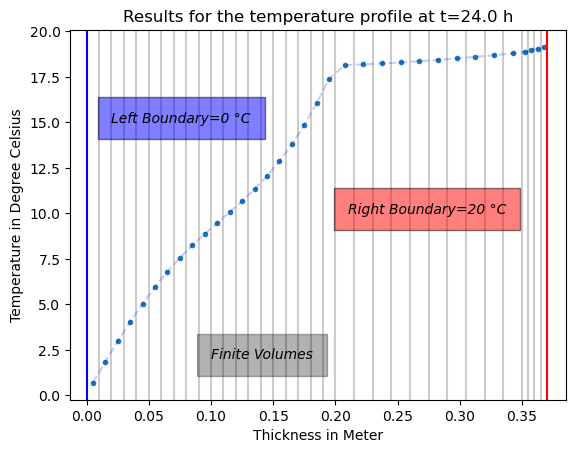

In [17]:
#  Plot tempfield to check
dx_array = np.array([cell.dx for cell in mat_domain])
d_array = np.cumsum(dx_array) - dx_array / 2

plt.plot(d_array, Tn[1:-1], '.')
plt.plot(d_array, Tn[1:-1], linestyle='dashed', alpha=0.2, color='b')
# plt.xticks(np.arange(min(d_array), max(d_array), 0.01))
for x in np.cumsum(dx_array):
    plt.axvline(x, alpha=0.2, color='black')
plt.axvline(0, alpha=1, color='blue')
plt.axvline(np.cumsum(dx_array)[-1], alpha=1, color='red')
plt.annotate(xy=(10, 10), text='Left Boundary', fontsize=22)
# plt.text(-5, 60, 'Right Boundary', fontsize=22)
plt.text(0.02, 15, f'Left Boundary={BC_left[0].Tn} °C', style='italic', bbox={
    'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})
plt.text(0.21, 10, f'Right Boundary={BC_right[0].Tn} °C', style='italic', bbox={
    'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.text(0.10, 2, 'Finite Volumes', style='italic', bbox={
    'facecolor': 'black', 'alpha': 0.3, 'pad': 10})
plt.title(f'Results for the temperature profile at t={sim_time / 3600} h')

plt.xlabel('Thickness in Meter')
plt.ylabel('Temperature in Degree Celsius')
plt.show()

## Stationary Calculation

To check how the stationary calculation for the materials would look like, we rewrite the equation for the stationary case, setting $\frac{dT}{dt} = 0$

$$
0 = \nabla (\lambda \nabla T)
$$

To reuse our implementaton of the numerical solution for the instationary problem, we will rearrange the conductivity-matrix $K$, and the solution vector and create an LES for the stationary problem in the form:

$$
Ax =b
$$

Here $A$ will be our modified conductivity matrix, $x$ the vector of the unknown temperatures and $b$ will be the vector for our known boundary condition.

In [24]:
K_stat = K * cp_P_constants * rho_P_constants * dx_P_constants / dt
K_staat_new = K_stat[1:-1, 1:-1]

In [25]:
num_cells_mat = mat_domain.__len__()
b = np.zeros(num_cells_mat)
b[0] = -K_stat[1, 0] * Tn[0]
b[-1] = - K_stat[-2, -1] * Tn[-1]
K_stat[-2, -1]

18.94736842105263

In [26]:
T_stat = np.linalg.solve(K_staat_new, b)

#### Plot

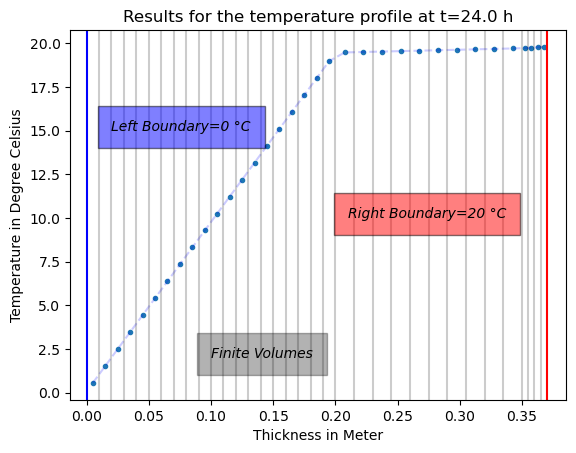

In [27]:
# plt.plot(T_stat, '.')
#  Plot tempfield to check
dx_array = np.array([cell.dx for cell in mat_domain])
d_array = np.cumsum(dx_array) - dx_array / 2

plt.plot(d_array, T_stat, '.')
plt.plot(d_array, T_stat, linestyle='dashed', alpha=0.2, color='b')
# plt.xticks(np.arange(min(d_array), max(d_array), 0.01))
for x in np.cumsum(dx_array):
    plt.axvline(x, alpha=0.2, color='black')
plt.axvline(0, alpha=1, color='blue')
plt.axvline(np.cumsum(dx_array)[-1], alpha=1, color='red')
plt.annotate(xy=(10, 10), text='Left Boundary', fontsize=22)
# plt.text(-5, 60, 'Right Boundary', fontsize=22)
plt.text(0.02, 15, f'Left Boundary={BC_left[0].Tn} °C', style='italic', bbox={
    'facecolor': 'blue', 'alpha': 0.5, 'pad': 10})
plt.text(0.21, 10, f'Right Boundary={BC_right[0].Tn} °C', style='italic', bbox={
    'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.text(0.10, 2, 'Finite Volumes', style='italic', bbox={
    'facecolor': 'black', 'alpha': 0.3, 'pad': 10})
plt.title(f'Results for the temperature profile at t={sim_time / 3600} h')

plt.xlabel('Thickness in Meter')
plt.ylabel('Temperature in Degree Celsius')
plt.show()